**EDA: Exploratory Data Analysis**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.util import ngrams

In [2]:
train_data = pd.read_csv("pre_train.csv")
val_data = pd.read_csv("pre_val.csv")


In [3]:
train_text = train_data['phrases'].dropna()
val_text = val_data['phrases'].dropna()

In [4]:
combined_text = pd.concat([train_text, val_text])

**1.Total number of unique words**

In [5]:
vectorizer = CountVectorizer()
word_matrix = vectorizer.fit_transform(combined_text)
unique_words = vectorizer.get_feature_names_out()
print(f"Total unique words: {len(unique_words)}")

Total unique words: 38174


**2.Most common words**

In [6]:
# 2. Most common words (graph)
word_counts = word_matrix.sum(axis=0).A1
word_freq = dict(zip(unique_words, word_counts))
common_words = Counter(word_freq).most_common(20)

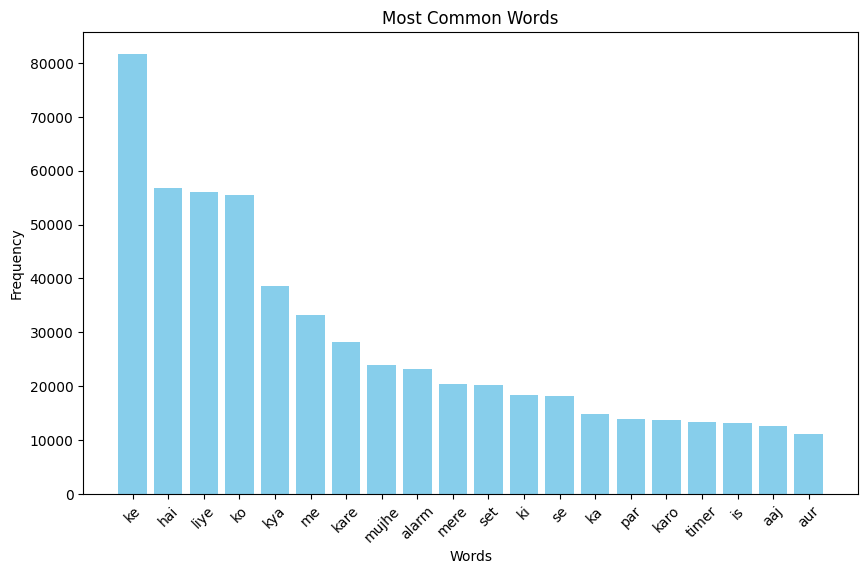

In [7]:
words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words")
plt.xticks(rotation=45)
plt.show()

**3.Text length distribution**

In [8]:
train_lengths = train_text.str.split().str.len()
val_lengths = val_text.str.split().str.len()

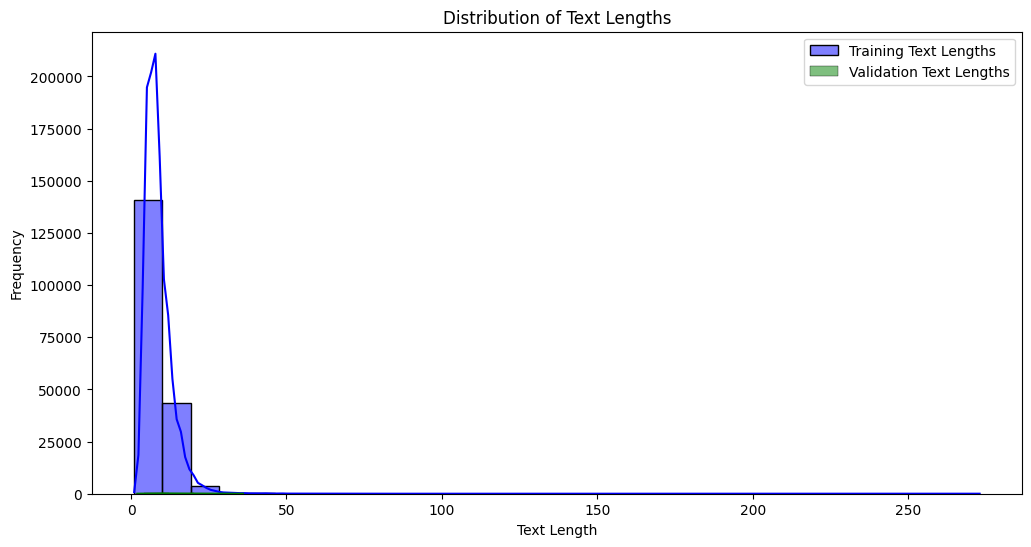

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(train_lengths, color='blue', kde=True, label='Training Text Lengths', bins=30)
sns.histplot(val_lengths, color='green', kde=True, label='Validation Text Lengths', bins=30)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.legend()
plt.show()

**4. Word Cloud for the combined dataset**

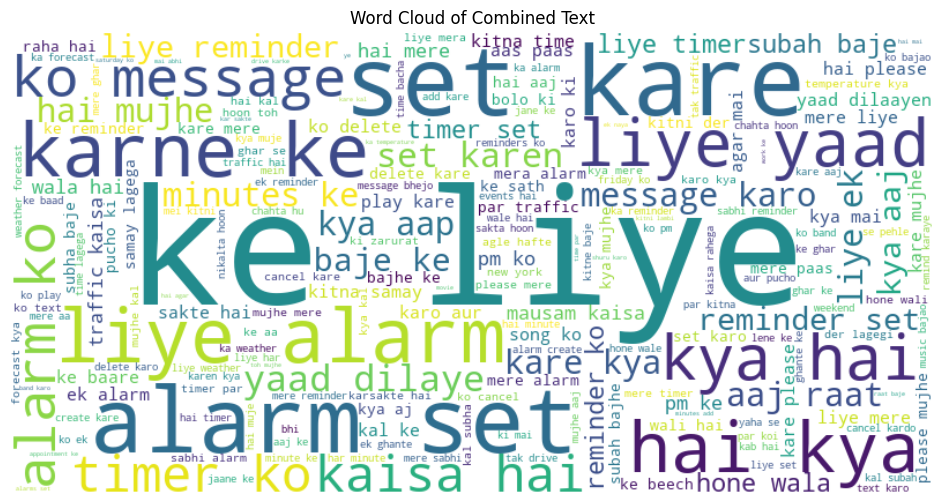

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(combined_text))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Combined Text")
plt.show()

**5. Unique Word Ratio**

In [11]:
def unique_word_ratio(text_series):
    return text_series.str.split().apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)

In [12]:
train_unique_ratio = unique_word_ratio(train_text)
val_unique_ratio = unique_word_ratio(val_text)

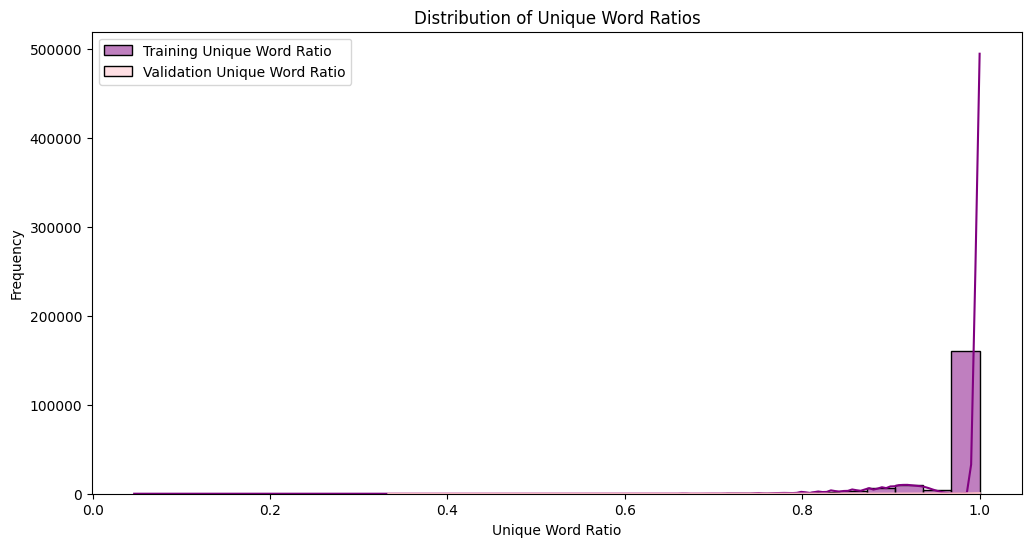

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(train_unique_ratio, color='purple', kde=True, label='Training Unique Word Ratio', bins=30)
sns.histplot(val_unique_ratio, color='pink', kde=True, label='Validation Unique Word Ratio', bins=30)
plt.xlabel("Unique Word Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Unique Word Ratios")
plt.legend()
plt.show()

**6. N-gram Analysis (Bigrams and Trigrams)**

In [14]:
def get_ngrams(text_series, n=2, top_n=10):
    ngram_list = []
    for text in text_series:
        tokens = text.split()
        ngram_list.extend([' '.join(gram) for gram in ngrams(tokens, n)])
    return Counter(ngram_list).most_common(top_n)


**(a)Bigrams**

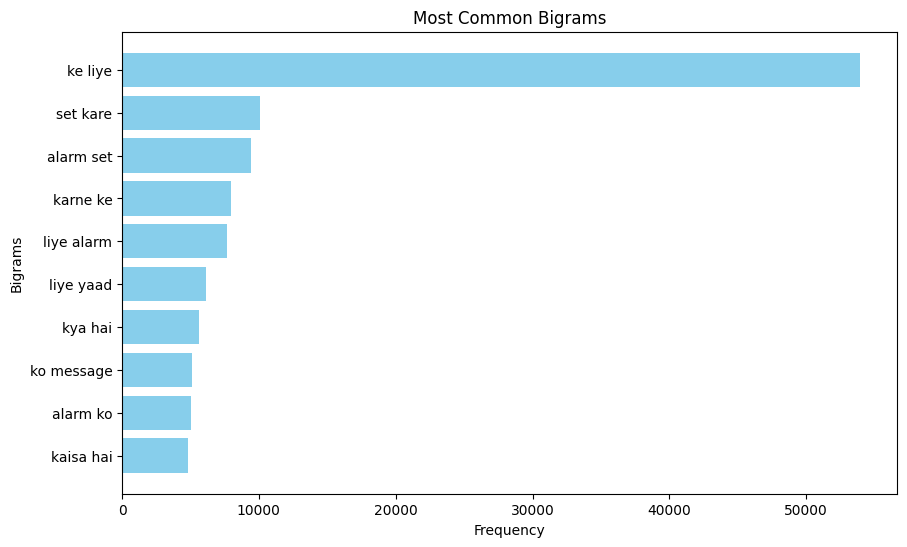

In [15]:
bigrams = get_ngrams(combined_text, n=2)

bigram_words, bigram_counts = zip(*bigrams)
plt.figure(figsize=(10, 6))
plt.barh(bigram_words, bigram_counts, color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.title("Most Common Bigrams")
plt.gca().invert_yaxis()
plt.show()

**(b)Trigrams**

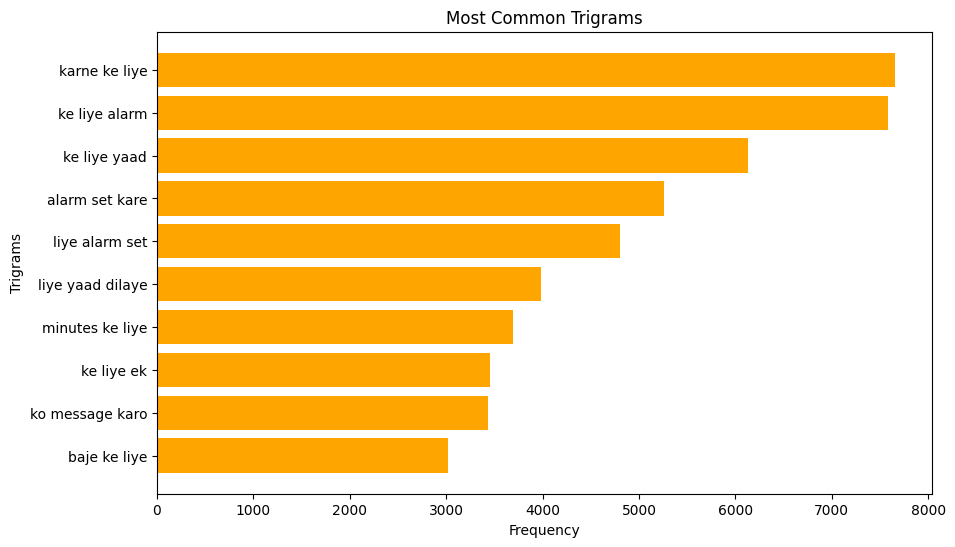

In [16]:
trigrams = get_ngrams(combined_text, n=3)

trigram_words, trigram_counts = zip(*trigrams)
plt.figure(figsize=(10, 6))
plt.barh(trigram_words, trigram_counts, color='orange')
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.title("Most Common Trigrams")
plt.gca().invert_yaxis()
plt.show()

**7. Jaccard similarity measure**

In [17]:
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2)

In [18]:
train_tokens = [word for text in train_text for word in text.split()]
val_tokens = [word for text in val_text for word in text.split()]

jaccard_sim = jaccard_similarity(train_tokens, val_tokens)
print(f"Jaccard Similarity: {jaccard_sim:.4f}")

Jaccard Similarity: 0.1891


**8 Cosine similarity measure**

In [19]:
cos_sim = cosine_similarity(word_matrix[:len(train_text)], word_matrix[len(train_text):])
avg_cosine_sim = np.mean(cos_sim)
print(f"Average Cosine Similarity: {avg_cosine_sim:.4f}")

Average Cosine Similarity: 0.0329


**9.Visualizing Word Similarities Using TSNE**

In [20]:
# Graph with similar words appearing closer
# Use TSNE on a reduced word matrix for visualization
top_indices = np.argsort(-word_counts)[:1000]  # Most frequent 1000 words
word_embeddings = word_matrix[:, top_indices].T

In [21]:
# Dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
reduced_embeddings = tsne.fit_transform(word_embeddings.toarray())


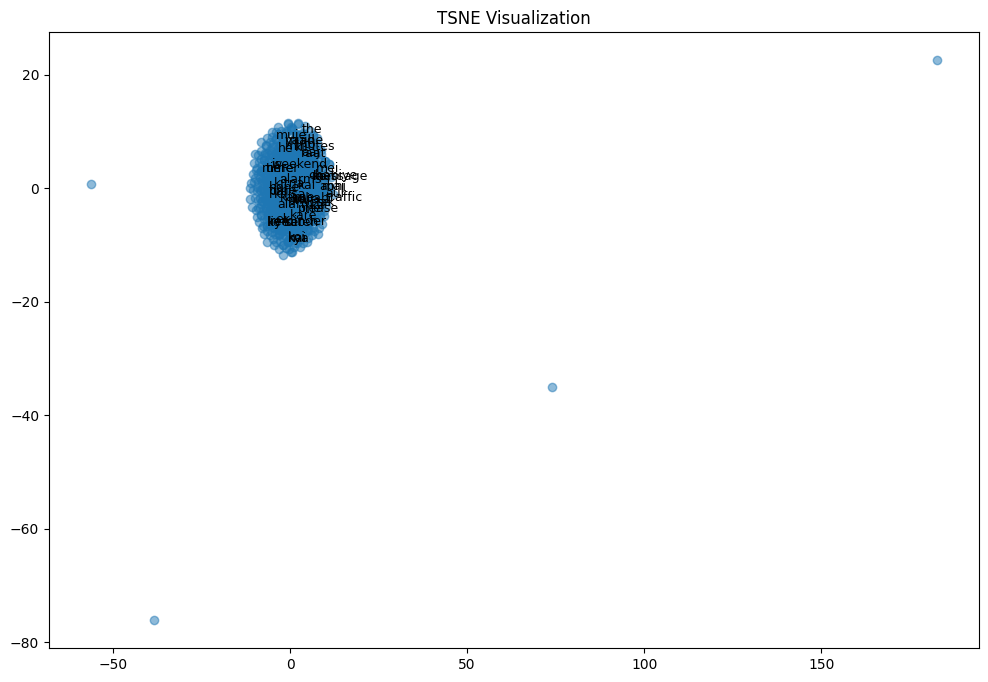

In [22]:
# TSNE Visualization
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
for i, word in enumerate(np.array(unique_words)[top_indices[:50]]):  # Annotate first 50 words
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=9)
plt.title("TSNE Visualization")
plt.show()